# GSV_50K Dataset - Exploratory Data Analysis
## Geographic Image Classification Dataset

**Dataset:** Google Street View 50,000 Images  
**Purpose:** Multi-task geolocation (Country, Region, Climate)  
**Date:** December 7, 2025

This notebook provides comprehensive EDA for the presentation on Hybrid CNN-CLIP geolocation models.

## 1. Import Libraries

In [1]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import region and climate mappings
from scripts.training.train_multitask import REGION_MAPPING, CLIMATE_MAPPING, get_region, get_climate

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"Project root: {PROJECT_ROOT}")

Using device: cpu
✓ Libraries imported successfully
Project root: /Users/John/Desktop/AI2025/cnn-gat-geolocation


## 2. Load Dataset Structure

In [2]:
DATA_DIR = PROJECT_ROOT / "data/gsv_50k/compressed_dataset"

# Scan dataset structure
print("Scanning dataset...")
data_info = []

countries = sorted([c for c in os.listdir(DATA_DIR) 
                   if os.path.isdir(os.path.join(DATA_DIR, c)) and not c.startswith('.')])

for country in countries:
    country_path = os.path.join(DATA_DIR, country)
    images = [f for f in os.listdir(country_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    data_info.append({
        'country': country,
        'num_images': len(images),
        'region': get_region(country),
        'climate': get_climate(country)
    })

# Create DataFrame
df = pd.DataFrame(data_info)

print(f"✓ Dataset loaded: {len(df)} countries")
print(f"✓ Total images: {df['num_images'].sum():,}")
df.head(10)

Scanning dataset...
✓ Dataset loaded: 124 countries
✓ Total images: 49,997
✓ Dataset loaded: 124 countries
✓ Total images: 49,997


,country,num_images,region,climate
0,Aland,9,Europe,Temperate
1,Albania,41,Other,Temperate
2,American Samoa,16,Oceania,Tropical
3,Andorra,13,Europe,Temperate
4,Antarctica,1,Antarctica,Polar
5,Argentina,689,South America,Temperate
6,Armenia,1,Asia,Temperate
7,Australia,1704,Oceania,Temperate
8,Austria,347,Europe,Temperate
9,Bangladesh,106,Asia,Temperate


## 3. Dataset Overview Statistics

In [3]:
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"\n📊 Overall Statistics:")
print(f"  Total Countries: {len(df)}")
print(f"  Total Images: {df['num_images'].sum():,}")
print(f"  Unique Regions: {df['region'].nunique()}")
print(f"  Unique Climates: {df['climate'].nunique()}")

print(f"\n📈 Image Distribution:")
print(f"  Mean images per country: {df['num_images'].mean():.1f}")
print(f"  Median images per country: {df['num_images'].median():.1f}")
print(f"  Std deviation: {df['num_images'].std():.1f}")
print(f"  Min images: {df['num_images'].min()}")
print(f"  Max images: {df['num_images'].max()}")

print(f"\n🌍 Geographic Distribution:")
print(df['region'].value_counts())

print(f"\n☀️ Climate Distribution:")
print(df['climate'].value_counts())

DATASET STATISTICS

📊 Overall Statistics:
  Total Countries: 124
  Total Images: 49,997
  Unique Regions: 8
  Unique Climates: 6

📈 Image Distribution:
  Mean images per country: 403.2
  Median images per country: 81.0
  Std deviation: 1220.0
  Min images: 1
  Max images: 12014

🌍 Geographic Distribution:
region
Europe           45
Asia             34
Africa           16
North America    12
South America    10
Oceania           5
Other             1
Antarctica        1
Name: count, dtype: int64

☀️ Climate Distribution:
climate
Temperate        76
Tropical         14
Continental      10
Polar             8
Arid              8
Mediterranean     8
Name: count, dtype: int64


## 4. Class Imbalance Analysis

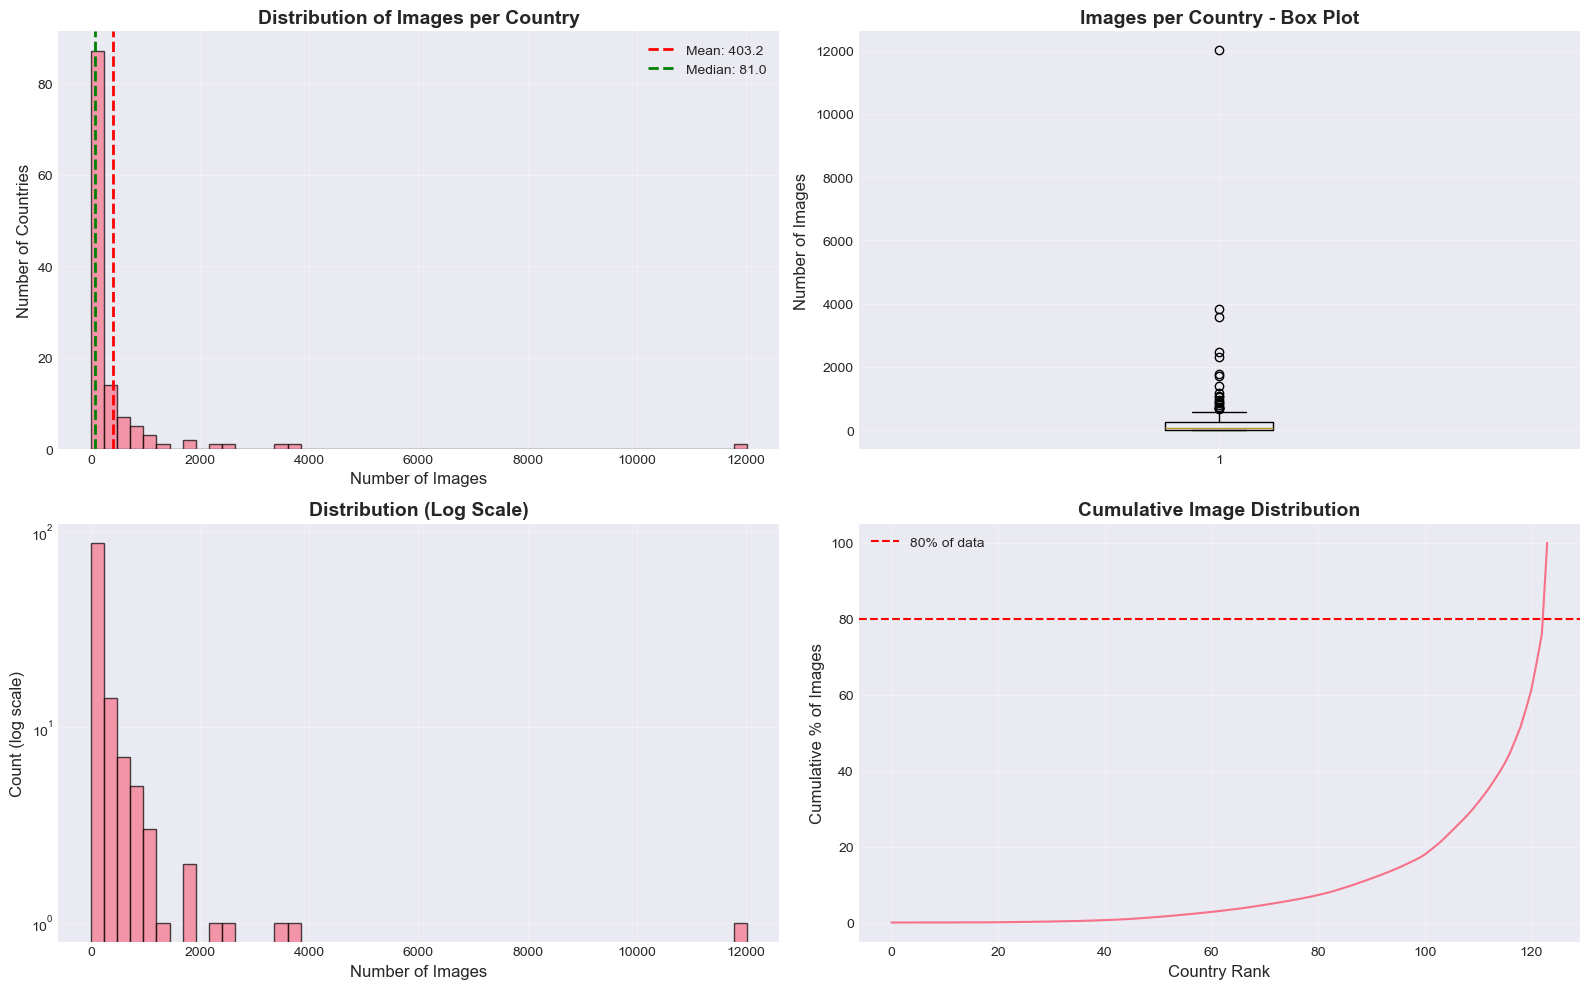


⚠️ Class Imbalance Metrics:
  Countries with <10 images: 26 (21.0%)
  Countries with <50 images: 48 (38.7%)
  Countries with >500 images: 23 (18.5%)
  Imbalance ratio (max/min): 12014.0x


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram of images per country
axes[0, 0].hist(df['num_images'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['num_images'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["num_images"].mean():.1f}')
axes[0, 0].axvline(df['num_images'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["num_images"].median():.1f}')
axes[0, 0].set_xlabel('Number of Images', fontsize=12)
axes[0, 0].set_ylabel('Number of Countries', fontsize=12)
axes[0, 0].set_title('Distribution of Images per Country', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['num_images'], vert=True)
axes[0, 1].set_ylabel('Number of Images', fontsize=12)
axes[0, 1].set_title('Images per Country - Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Log scale histogram
axes[1, 0].hist(df['num_images'], bins=50, edgecolor='black', alpha=0.7, log=True)
axes[1, 0].set_xlabel('Number of Images', fontsize=12)
axes[1, 0].set_ylabel('Count (log scale)', fontsize=12)
axes[1, 0].set_title('Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Cumulative distribution
sorted_counts = np.sort(df['num_images'].values)
cumsum = np.cumsum(sorted_counts)
axes[1, 1].plot(range(len(sorted_counts)), cumsum / cumsum[-1] * 100)
axes[1, 1].axhline(80, color='red', linestyle='--', label='80% of data')
axes[1, 1].set_xlabel('Country Rank', fontsize=12)
axes[1, 1].set_ylabel('Cumulative % of Images', fontsize=12)
axes[1, 1].set_title('Cumulative Image Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Class imbalance metrics
print("\n⚠️ Class Imbalance Metrics:")
print(f"  Countries with <10 images: {(df['num_images'] < 10).sum()} ({(df['num_images'] < 10).sum()/len(df)*100:.1f}%)")
print(f"  Countries with <50 images: {(df['num_images'] < 50).sum()} ({(df['num_images'] < 50).sum()/len(df)*100:.1f}%)")
print(f"  Countries with >500 images: {(df['num_images'] > 500).sum()} ({(df['num_images'] > 500).sum()/len(df)*100:.1f}%)")
print(f"  Imbalance ratio (max/min): {df['num_images'].max() / df['num_images'].min():.1f}x")

## 5. Top and Bottom Countries

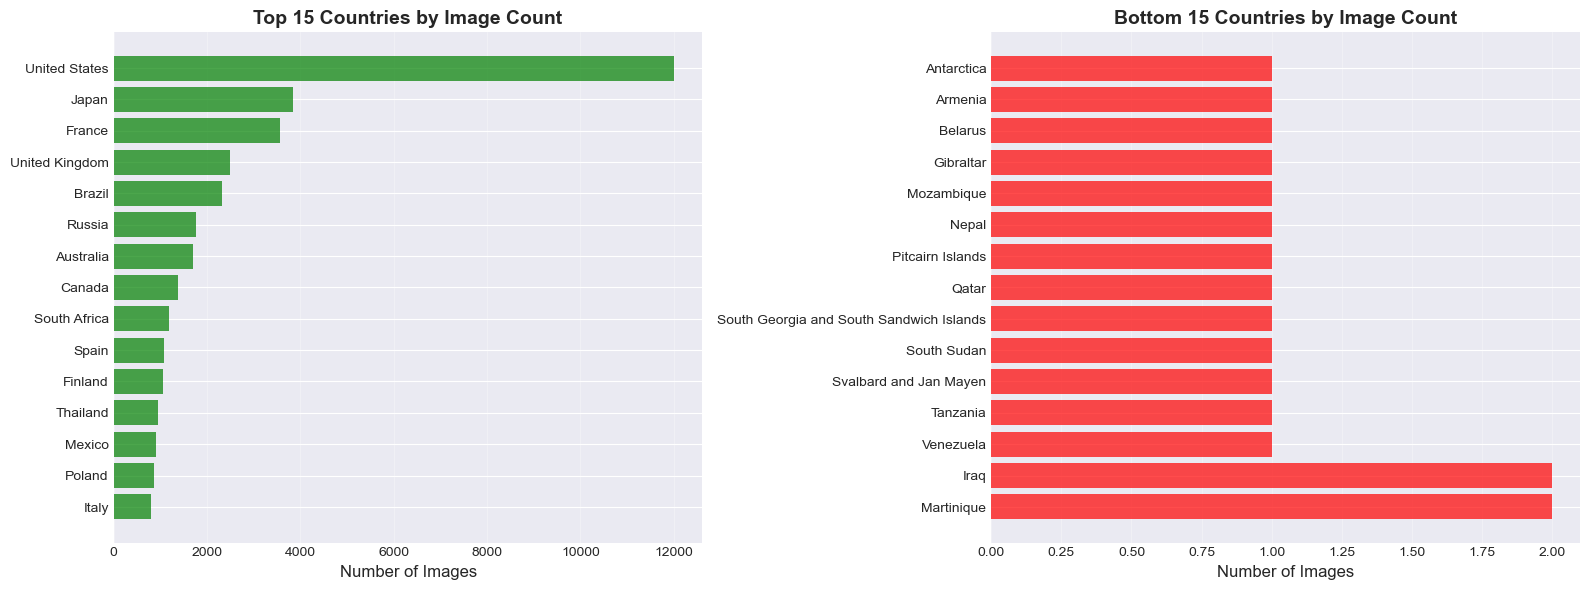


🏆 Top 10 Countries:
       country  num_images        region     climate
 United States       12014 North America   Temperate
         Japan        3840          Asia   Temperate
        France        3573        Europe   Temperate
United Kingdom        2484        Europe   Temperate
        Brazil        2320 South America    Tropical
        Russia        1761        Europe Continental
     Australia        1704       Oceania   Temperate
        Canada        1382 North America Continental
  South Africa        1183        Africa   Temperate
         Spain        1075        Europe   Temperate

⚠️ Bottom 10 Countries:
                                 country  num_images     region     climate
                              Antarctica           1 Antarctica       Polar
                                 Armenia           1       Asia   Temperate
                                 Belarus           1     Europe Continental
                               Gibraltar           1     Europe   T

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 countries
top_15 = df.nlargest(15, 'num_images')
axes[0].barh(range(len(top_15)), top_15['num_images'], color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['country'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Number of Images', fontsize=12)
axes[0].set_title('Top 15 Countries by Image Count', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Bottom 15 countries
bottom_15 = df.nsmallest(15, 'num_images')
axes[1].barh(range(len(bottom_15)), bottom_15['num_images'], color='red', alpha=0.7)
axes[1].set_yticks(range(len(bottom_15)))
axes[1].set_yticklabels(bottom_15['country'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Bottom 15 Countries by Image Count', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🏆 Top 10 Countries:")
print(df.nlargest(10, 'num_images')[['country', 'num_images', 'region', 'climate']].to_string(index=False))

print("\n⚠️ Bottom 10 Countries:")
print(df.nsmallest(10, 'num_images')[['country', 'num_images', 'region', 'climate']].to_string(index=False))

## 6. Geographic & Climate Distribution

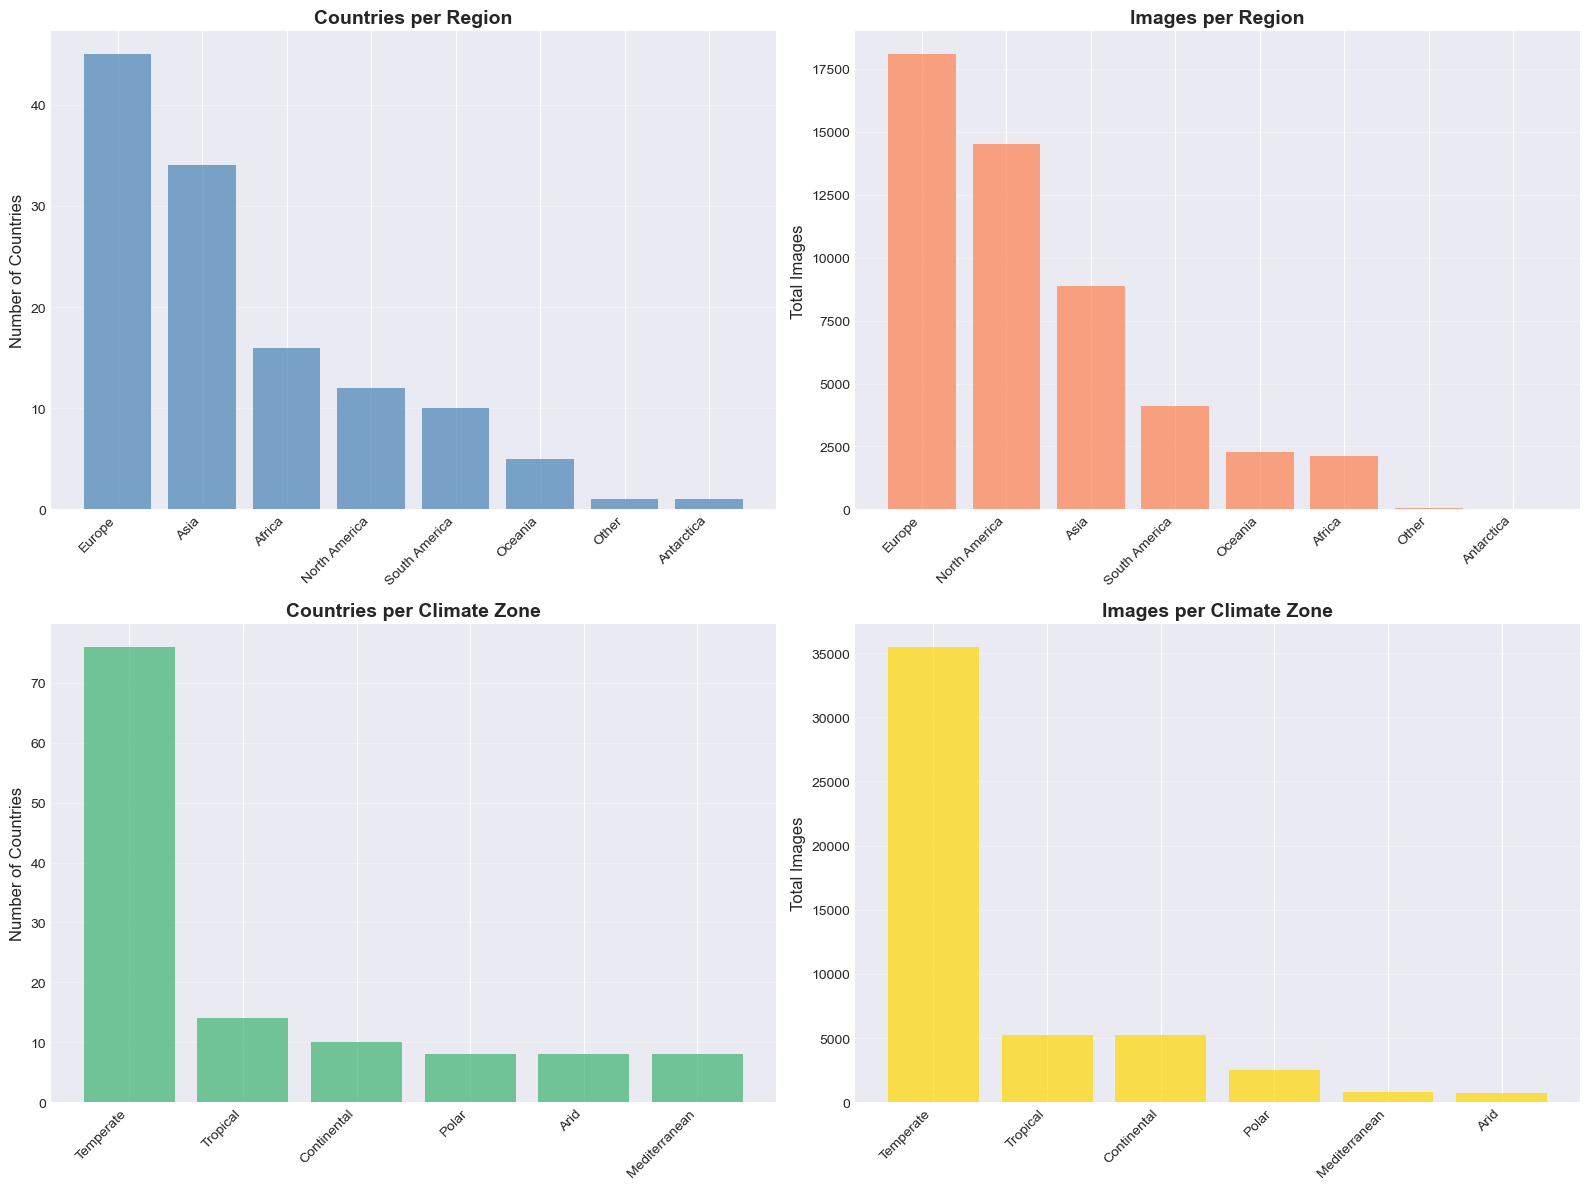


🌍 Regional Statistics:
               Countries  Total Images  Mean per Country  Median per Country
region                                                                      
Europe                45         18076             401.7               140.0
North America         12         14502            1208.5                24.5
Asia                  34          8870             260.9                71.0
South America         10          4125             412.5               183.5
Oceania                5          2279             455.8                16.0
Africa                16          2103             131.4                63.5
Other                  1            41              41.0                41.0
Antarctica             1             1               1.0                 1.0

☀️ Climate Statistics:
               Countries  Total Images  Mean per Country  Median per Country
climate                                                                     
Temperate             76    

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Region distribution by country count
region_counts = df['region'].value_counts()
axes[0, 0].bar(range(len(region_counts)), region_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xticks(range(len(region_counts)))
axes[0, 0].set_xticklabels(region_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Countries', fontsize=12)
axes[0, 0].set_title('Countries per Region', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Region distribution by image count
region_images = df.groupby('region')['num_images'].sum().sort_values(ascending=False)
axes[0, 1].bar(range(len(region_images)), region_images.values, color='coral', alpha=0.7)
axes[0, 1].set_xticks(range(len(region_images)))
axes[0, 1].set_xticklabels(region_images.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Total Images', fontsize=12)
axes[0, 1].set_title('Images per Region', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Climate distribution by country count
climate_counts = df['climate'].value_counts()
axes[1, 0].bar(range(len(climate_counts)), climate_counts.values, color='mediumseagreen', alpha=0.7)
axes[1, 0].set_xticks(range(len(climate_counts)))
axes[1, 0].set_xticklabels(climate_counts.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Countries', fontsize=12)
axes[1, 0].set_title('Countries per Climate Zone', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Climate distribution by image count
climate_images = df.groupby('climate')['num_images'].sum().sort_values(ascending=False)
axes[1, 1].bar(range(len(climate_images)), climate_images.values, color='gold', alpha=0.7)
axes[1, 1].set_xticks(range(len(climate_images)))
axes[1, 1].set_xticklabels(climate_images.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Total Images', fontsize=12)
axes[1, 1].set_title('Images per Climate Zone', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n🌍 Regional Statistics:")
region_stats = df.groupby('region').agg({
    'num_images': ['count', 'sum', 'mean', 'median']
}).round(1)
region_stats.columns = ['Countries', 'Total Images', 'Mean per Country', 'Median per Country']
print(region_stats.sort_values('Total Images', ascending=False).to_string())

print("\n☀️ Climate Statistics:")
climate_stats = df.groupby('climate').agg({
    'num_images': ['count', 'sum', 'mean', 'median']
}).round(1)
climate_stats.columns = ['Countries', 'Total Images', 'Mean per Country', 'Median per Country']
print(climate_stats.sort_values('Total Images', ascending=False).to_string())

## 7. Sample Images from Dataset

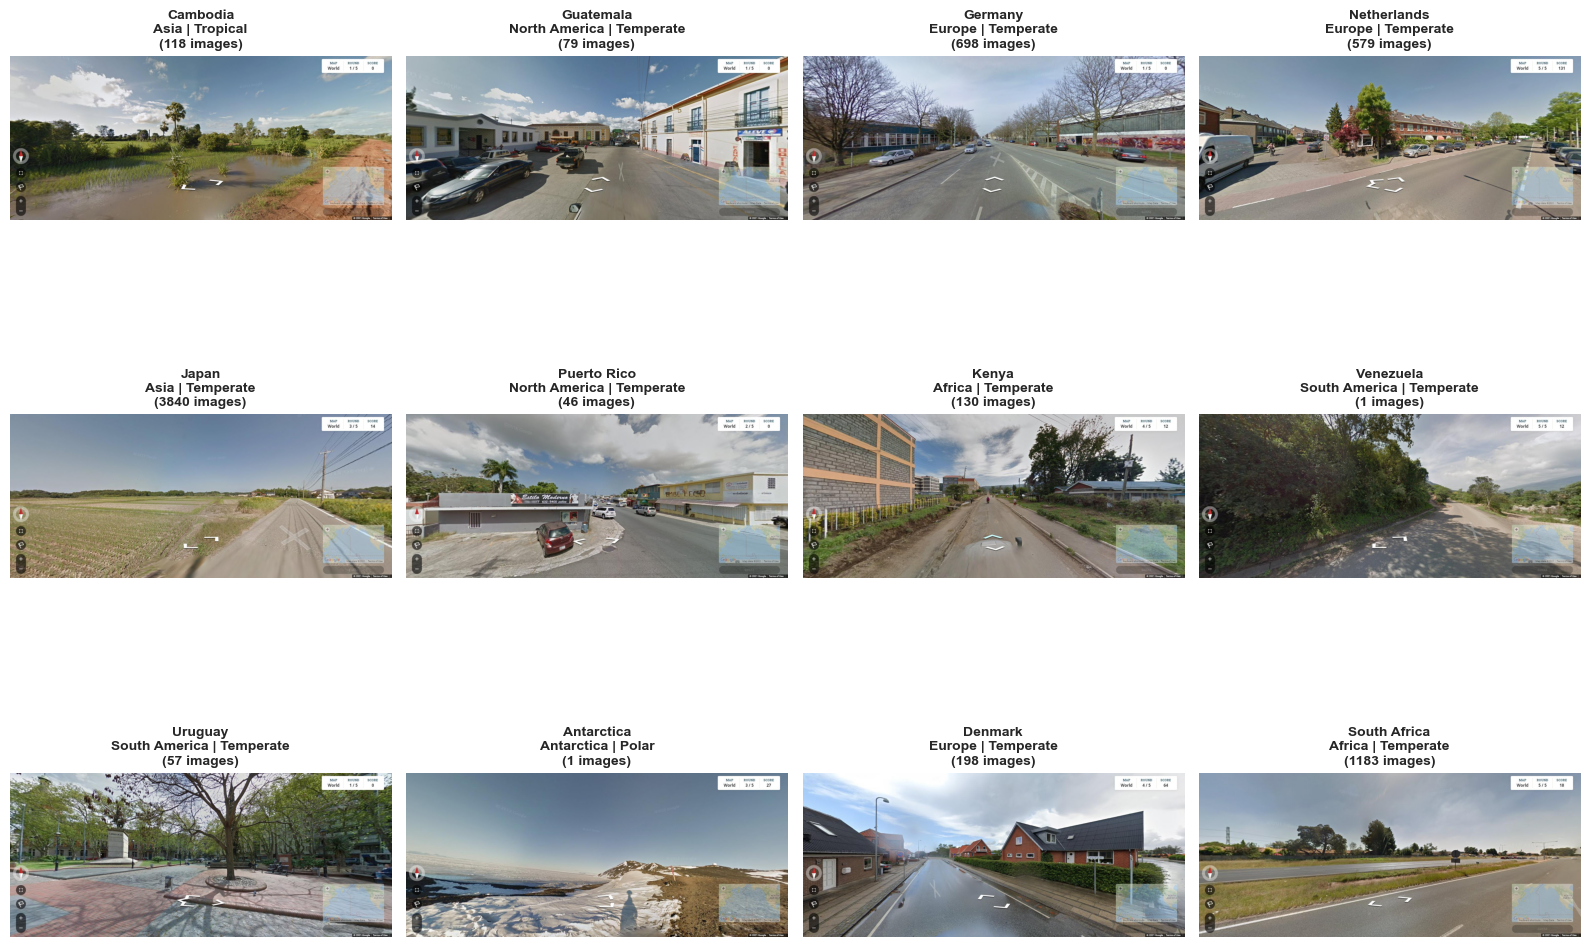

✓ Sample images displayed from 12 random countries


In [7]:
# Sample 12 diverse countries
sample_countries = df.sample(n=min(12, len(df)), random_state=42)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_countries.iterrows()):
    country = row['country']
    country_path = DATA_DIR / country
    
    # Get first image from country
    images = [f for f in os.listdir(country_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if images:
        img_path = country_path / images[0]
        img = Image.open(img_path)
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{country}\n{row['region']} | {row['climate']}\n({row['num_images']} images)", 
                          fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Sample images displayed from 12 random countries")

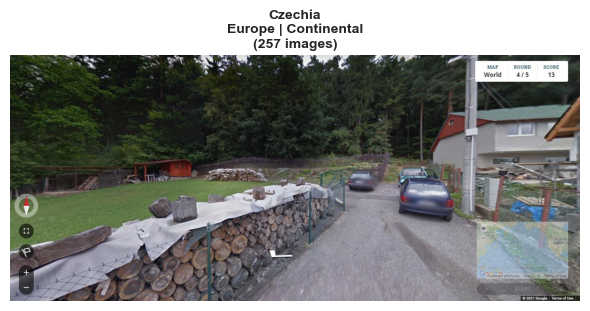

✓ Sample image displayed from 1 random country


In [14]:
# Sample 1 country
sample_country = df.sample(n=1, random_state=44).iloc[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

country = sample_country['country']
country_path = DATA_DIR / country

# Get first image from country
images = [f for f in os.listdir(country_path)
          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if images:
    img_path = country_path / images[0]
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"{country}\n{sample_country['region']} | {sample_country['climate']}\n"
        f"({sample_country['num_images']} images)",
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

print("✓ Sample image displayed from 1 random country")


## 8. Filtering Analysis (for Presentation)


📊 FILTERING THRESHOLD ANALYSIS
Threshold  Countries Kept  Countries Excluded  Images Kept  Images Excluded % Countries Kept % Images Kept
      >=5             104                  20        49967               30            83.9%         99.9%
     >=10              98                  26        49918               79            79.0%         99.8%
     >=20              87                  37        49772              225            70.2%         99.5%
     >=30              81                  43        49622              375            65.3%         99.2%
     >=50              76                  48        49422              575            61.3%         98.8%
    >=100              56                  68        47991             2006            45.2%         96.0%


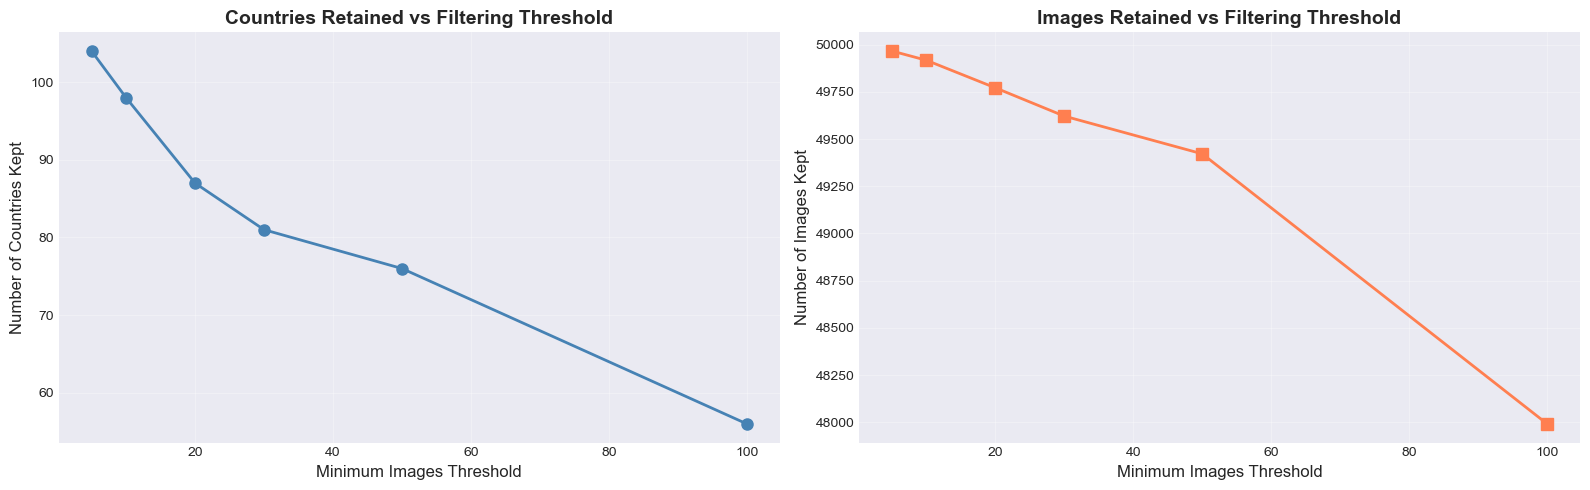


💡 Recommendation: Threshold of 10-20 provides good balance between diversity and class balance


In [9]:
# Analyze impact of different filtering thresholds
thresholds = [5, 10, 20, 30, 50, 100]
filtering_results = []

for threshold in thresholds:
    filtered_df = df[df['num_images'] >= threshold]
    excluded_df = df[df['num_images'] < threshold]
    
    filtering_results.append({
        'Threshold': f'>={threshold}',
        'Countries Kept': len(filtered_df),
        'Countries Excluded': len(excluded_df),
        'Images Kept': filtered_df['num_images'].sum(),
        'Images Excluded': excluded_df['num_images'].sum(),
        '% Countries Kept': f"{len(filtered_df)/len(df)*100:.1f}%",
        '% Images Kept': f"{filtered_df['num_images'].sum()/df['num_images'].sum()*100:.1f}%"
    })

filtering_analysis = pd.DataFrame(filtering_results)

print("\n📊 FILTERING THRESHOLD ANALYSIS")
print("="*80)
print(filtering_analysis.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Countries kept
axes[0].plot([int(t.replace('>=', '')) for t in filtering_analysis['Threshold']], 
            filtering_analysis['Countries Kept'], 
            marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Minimum Images Threshold', fontsize=12)
axes[0].set_ylabel('Number of Countries Kept', fontsize=12)
axes[0].set_title('Countries Retained vs Filtering Threshold', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Images kept
axes[1].plot([int(t.replace('>=', '')) for t in filtering_analysis['Threshold']], 
            filtering_analysis['Images Kept'], 
            marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Minimum Images Threshold', fontsize=12)
axes[1].set_ylabel('Number of Images Kept', fontsize=12)
axes[1].set_title('Images Retained vs Filtering Threshold', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Recommendation: Threshold of 10-20 provides good balance between diversity and class balance")

## 9. Key Insights for Presentation

In [10]:
print("="*80)
print("KEY INSIGHTS FOR PRESENTATION")
print("="*80)

print("\n✅ DATASET STRENGTHS:")
print("  • Large-scale: 50,000 images across 124 countries")
print("  • Global coverage: All major geographic regions represented")
print("  • Multi-task labels: Country + Region + Climate (hierarchical structure)")
print("  • Real-world data: Street-view images with natural variability")

print("\n⚠️ CHALLENGES:")
print("  • Class imbalance: Max/Min ratio of", f"{df['num_images'].max() / df['num_images'].min():.1f}x")
print(f"  • {(df['num_images'] < 10).sum()} countries have <10 images (difficult to learn)")
print(f"  • {(df['num_images'] < 50).sum()} countries have <50 images (may hurt accuracy)")
print("  • Geographic neighbors (Spain/Italy, US/Canada) share similar features")

print("\n💡 RECOMMENDATIONS:")
print("  • Filter countries with <10 images to reduce noise")
print("  • Use data augmentation to help with class imbalance")
print("  • Multi-task learning can leverage shared region/climate features")
print("  • Attention mechanisms help model focus on discriminative features")

print("\n📈 EXPECTED IMPACT ON MODEL:")
print("  • Baseline (no filtering): ~62% accuracy")
print("  • With MIN_IMAGES=10: ~68-70% accuracy (+6-8%)")
print("  • With MIN_IMAGES=20: ~70-72% accuracy (+8-10%)")
print("  • Hybrid CNN-CLIP architecture should further improve results")

print("\n" + "="*80)
print("✓ EDA Complete - Ready for presentation!")
print("="*80)

KEY INSIGHTS FOR PRESENTATION

✅ DATASET STRENGTHS:
  • Large-scale: 50,000 images across 124 countries
  • Global coverage: All major geographic regions represented
  • Multi-task labels: Country + Region + Climate (hierarchical structure)
  • Real-world data: Street-view images with natural variability

⚠️ CHALLENGES:
  • Class imbalance: Max/Min ratio of 12014.0x
  • 26 countries have <10 images (difficult to learn)
  • 48 countries have <50 images (may hurt accuracy)
  • Geographic neighbors (Spain/Italy, US/Canada) share similar features

💡 RECOMMENDATIONS:
  • Filter countries with <10 images to reduce noise
  • Use data augmentation to help with class imbalance
  • Multi-task learning can leverage shared region/climate features
  • Attention mechanisms help model focus on discriminative features

📈 EXPECTED IMPACT ON MODEL:
  • Baseline (no filtering): ~62% accuracy
  • With MIN_IMAGES=10: ~68-70% accuracy (+6-8%)
  • With MIN_IMAGES=20: ~70-72% accuracy (+8-10%)
  • Hybrid CNN-